In [62]:
%load_ext autoreload

%autoreload 2

import gauleg as gl 
import sympy as sp 
import numpy as np 
import pandas as pd 
import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Solving Linear System


## Finding Lm Ln Polynomials 


In [63]:
def legendre_polynomial(n):
    y = sp.symbols('y')
    if n == 0:
        return sp.Lambda(y, 1)
    elif n == 1:
        return sp.Lambda(y, y)
    else:
        P_n_minus_1 = legendre_polynomial(n-1)
        P_n_minus_2 = legendre_polynomial(n-2)
        return sp.Lambda(y, ((2*n - 1) * y * P_n_minus_1(y) - (n - 1) * P_n_minus_2(y)) / n)

# Example usage:
n = 0
Ln = legendre_polynomial(n)
Ln


Lambda(y, 1)

## Computing Anm using GL Quadrature --> finding A 

In [64]:
n = [0]
m = [0]

def Anm(n, m):
    y = sp.symbols('y')
    Ln = legendre_polynomial(n)
    Lm = legendre_polynomial(m)
    return 0 * Ln(y) * Lm(y)
    #    return y * Ln(y) * Lm(y) for a non deterministic case

def Anm_gauleg(xi, ci, b , a, n2, n, m):
    sum = 0 
    Anm_expr = Anm(n,m)
    for i in range(n2):
        y_value = (0.5*(((b-a)*xi[i])+(b+a)))
        prod = ci[i]* Anm_expr.subs(sp.symbols('y'), y_value)
        sum = sum + prod 
    return sum 

def A_matrix(n,m):
    A_matrix = sp.zeros(len(n),len(m))
    n2 = math.floor((len(n)+len(m))/2) + 1
    xi = gl.gauleg(n2)[0] # satisfying dop of GL for p+1 is 2p + 1
    ci = gl.gauleg(n2)[1]
    for ni in n:
        for mi in m:
            A_matrix[ni ,mi] = Anm_gauleg(xi= xi, ci = ci, b = 1, a = -1, n2 = n2, n = ni, m = mi)

    return A_matrix

A = A_matrix(n,m)
A



Matrix([[0]])

## Define A(x,y) 

In [65]:


def a(x, y):
    return 2 + math.sin(x)


# def a0(x):
#     return 2 + math.sin(x)

def a0(x):
    if 0 <= x < 1/3: 
        return 1.0 
    elif 1/3 <= x <= 1:
        return 2.0

# def a0(x):
#     if 0 <= x < 0.5:
#         return 1
#     elif 0.5 <= x <= 1:
#         return 2

# def a0(x): 
#     if 0<= x < 0.75:
#         return 1 
#     elif 0.75<= x <= 1:
#         return 2

def a1(x):
    return 0 *x



## Define (S1) matrix and (S0) matrix

Error Indexing 

nodal index = (0,1,2,3,...,n) 

element index =(0,1,...,n-1) 

finite element function index =  nodal index = (0,1,2,3...) since phi_i(x_i) = 1 for all i

eg: nodal index = (0,1,2)

element index = (0,1)

element i = (x_i, x_i+1)

In [66]:
def GL(xi, ci, x_right, x_left, n2, func):
	sum = 0 
	for i in range(n2):
		prod = ci[i]*func(0.5*(((x_right-x_left)*xi[i])+(x_right+x_left)))
		sum = sum + prod 
	return (x_right-x_left)/2 * (sum)

def piecewise_GL(integrand, x_left, x_right, n2):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre,
    but if [x_left, x_right] crosses x=1/3, split it into two parts:
      [x_left, 1/3]  and  [1/3, x_right]
    and sum the results.
    """
    discont = 1/3
    xi, ci = gl.gauleg(n2) 
    # If the entire interval is on one side of 1/3, do one normal G-L integral
    if x_right <= discont or x_left >= discont:
        return GL(xi =  xi, ci = ci, x_left=x_left, x_right=x_right, func=integrand, n2=n2)

    # Otherwise, we split at x=1/3
    # part1 = integral from x_left..1/3
    part1 = GL(xi =  xi, ci = ci, x_left=x_left, x_right=discont, func=integrand, n2=n2)
    # part2 = integral from 1/3..x_right
    part2 = GL(xi =  xi, ci = ci, x_left=discont, x_right=x_right, func=integrand, n2=n2)

    return part1 + part2

def dphi_i_on_element(i, k, xlist):
    """
    Return the (constant) slope of the i-th shape function on the k-th subinterval
    [ x_k, x_{k+1} ] in a 1D mesh with nodes x_0 < ... < x_N.
    """
    if i == k:
        # node i is the left endpoint of the subinterval => slope from 1 at x_k down to 0 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return -1.0 / dx
    elif i == k+1:
        # node i is the right endpoint => slope from 0 at x_k up to 1 at x_{k+1}
        dx = xlist[k+1] - xlist[k]
        return +1.0 / dx
    else:
        return 0.0


def phiij(numofnodes, i, j, xlist, func):
    finalsum = 0
    for k in range(numofnodes-1):
        x_left = xlist[k]
        x_right = xlist[k+1]

        # Derivatives of shape functions phi_i, phi_j on element k
        d_phi_i = dphi_i_on_element(i, k, xlist)
        d_phi_j = dphi_i_on_element(j, k, xlist)
        def local_integrand(x_val):
            return func(x_val) * (d_phi_i * d_phi_j)

        # Now call piecewise_GL with local_integrand
        val = piecewise_GL(local_integrand, x_left, x_right, n2=5)
        finalsum += val
    return finalsum

def S1(func, mesh):
    I = list(range(1, len(mesh)-1))
    S1 = sp.zeros(len(I), len(I))
    target = func
    for local_i, g_i in enumerate(I):
            for local_j, g_j in enumerate(I):
                # 4) Evaluate your shape-function integral
                S1[local_i, local_j] = phiij(
                    numofnodes=len(mesh), 
                    i=g_i, 
                    j=g_j,
                    xlist=mesh,
                    func=func
                )

    return S1
initial_mesh = [0, 0.5, 1]
S1(func = a1, mesh = initial_mesh)


Matrix([[0]])

In [67]:
# compute S0 

def S0(func, mesh):
    I=list(range(1,len(mesh)-1))
    S0 = sp.zeros(len(I), len(I))
    target = func
    for local_i, g_i in enumerate(I):
            for local_j, g_j in enumerate(I):
                # 4) Evaluate your shape-function integral
                S0[local_i, local_j] = phiij(
                    numofnodes=len(mesh), 
                    i=g_i, 
                    j=g_j,
                    xlist=mesh,
                    func= target
                )

    return S0

S0(func= a0, mesh= initial_mesh)


Matrix([[6.66666666666667]])

In [68]:
phiij(numofnodes=3, i = 1, j = 1, xlist = initial_mesh, func = a0)

6.666666666666667

## Define Kroneker Notation 


In [69]:
# n, m are integers, probably need to loop it for every possible n, m 

def delta_mn(m,n):
    if n == m:
        return 1 
    else:
        return 0 

def delta(n,m):
    delta = sp.zeros(len(n), len(m))
    for ni in n:
        for mi in m: 
            delta[ni,mi] = delta_mn(ni,mi)

    return delta 

delta(n,m)

Matrix([[1]])

## Kron Matrix A and S1 

In [70]:
def A_S1(matrixA, matrixS1):
    A_S1 = sp.kronecker_product(matrixA, matrixS1)
    return A_S1

A_S1(matrixA= A_matrix(n= n, m= m), matrixS1= S1(func = a1, mesh = initial_mesh))


Matrix([[0]])

## Define S0 * delta_mn


In [71]:
def S0_delta(matrixS0, matrixdelta):
    return sp.kronecker_product(matrixS0 , matrixdelta) 

S0_delta(matrixS0=S0(func = a0, mesh = initial_mesh), matrixdelta=delta(n,m))

Matrix([[6.66666666666667]])

## Define S(in)(jm)


In [72]:
def S_in_jm(matrixS1_Amn, matrixS0_delta):
    return matrixS0_delta + matrixS1_Amn

S_in_jm(matrixS1_Amn= A_S1(matrixA=A_matrix(n,m), matrixS1=S1(func= a1, mesh = initial_mesh)),
         matrixS0_delta=S0_delta(matrixS0=S0(func = a0, mesh = initial_mesh), matrixdelta=delta(n,m)))

Matrix([[6.66666666666667]])

## Define Fi and F 

In [73]:
def phi(i, s, xlist):
    """
    Evaluate the piecewise-linear hat function phi_i at point s,
    given the node array xlist = [x_0, x_1, ..., x_N].
    """
    # Find which interval [x_k,x_{k+1}] contains s
    # If s < x_0 or s > x_N, phi_i(s)=0 outside domain
    if s < xlist[0] or s > xlist[-1]:
        return 0.0

    # Find k: x_k <= s < x_{k+1}
    k_found = None
    for k in range(len(xlist)-1):
        if xlist[k] <= s < xlist[k+1]:
            k_found = k
            break
    # handle s == xlist[-1]
    if s == xlist[-1]:
        k_found = len(xlist)-2

    # Cases:
    # 1) If i not in {k,k+1}, phi_i(s)=0 in that subinterval
    if i != k and i != k+1:
        return 0.0

    # 2) If i == k, then phi_i goes from 1 at x_k to 0 at x_{k+1}
    if i == k:
        dx = xlist[k+1] - xlist[k]
        # linear from phi_i(x_k)=1 to phi_i(x_{k+1})=0
        # slope = -1/dx
        return 1.0 - (s - xlist[k]) / dx

    # 3) If i == k+1, then phi_i goes from 0 at x_k to 1 at x_{k+1}
    elif i == k+1:
        dx = xlist[k+1] - xlist[k]
        return (s - xlist[k]) / dx
    
def integrand_for_force(i, xlist, f, xi, ci, n2):
    """
    Compute \int f(s)*phi_i(s) ds over the entire domain,
    by summing subinterval integrals or a single Gauss-Legendre over [0,1].
    But typically we do subinterval-based integration for a non-uniform mesh.
    """
    # We'll do an element-by-element integration approach:
    total = 0.0
    for k in range(len(xlist)-1):
        x_left = xlist[k]
        x_right = xlist[k+1]
        # do Gauss-Legendre on each subinterval
        sum_local = 0.0
        for j in range(n2):
            s = 0.5*((x_right - x_left)*xi[j] + (x_left + x_right))
            w = ci[j]
            val = f(s)*phi(i, s, xlist)
            sum_local += w*val
        total += 0.5*(x_right - x_left)*sum_local
    return total

# def f(s): 
#     return 2* (2 + math.sin(s)) - math.cos(s) *(1 -2*s)

def f(s):
    if 0 <= s < 1/3:
        return 2.0
    elif 1/3 <= s <= 1:
        return 4.0

# def f(s):
#     if 0 <= s < 0.5:
#         return 2
#     elif 0.5 <= s <= 1:
#         return 4
    
# def f(s):
#     if 0 <= s < 0.75:
#         return 2
#     elif 0.75 <= s <= 1: 
#         return 4


# def build_force_vector(num_nodes, xlist, f):
#     """
#     Build the vector F of length num_nodes where
#     F[i] = \int f(x)*phi_i(x) dx
#     """
#     interior = list(range(1, len(xlist)-1))
#     num_interior = len(interior)

#     # 2) Create a vector of that size
#     F_interior = sp.zeros(num_interior, 1)

#     # 3) Gauss-Legendre setup
#     n2 = 5
#     xi, ci = gl.gauleg(n2)

#     # 4) Fill each entry for the interior node i
#     for local_i, global_i in enumerate(interior):
#         val = integrand_for_force(global_i, xlist, f, xi, ci, n2)
#         F_interior[local_i, 0] = val
#         print(local_i, global_i, val)

#     return F_interior

# build_force_vector(num_nodes=len(initial_mesh), xlist = initial_mesh, f = f)

In [74]:
def build_force_vector2(num_nodes, xlist, n_list, f):
    """
    Build the interior force vector F where
      F[i] = ∫ f(x)*phi_i(x) dx
    skipping boundary shape functions (i=0, i=N).
    """
    interior = range(1, len(xlist)-1)   # interior node indices
    F_interior = sp.zeros(len(interior) * len(n_list), 1)

    n2 = 5
    xi, ci = gl.gauleg(n2)

    def phi_i(i, x):
        return phi(i, x, xlist)  # your standard piecewise "hat" function

    # local routine to integrate f(x)*phi_i(x) over [a,b], 
    # handling the 1/3 discontinuity
    def piecewise_integral(a, b, i):
        # if entire [a,b] is below 1/3 or above 1/3, do one G-L integral
        discont = 1/3
        if b <= discont or a >= discont:
            return gauss_legendre_integrate(a, b, i) 
        # otherwise split at x=1/3
        part1 = gauss_legendre_integrate(a, discont, i)
        part2 = gauss_legendre_integrate(discont, b, i)
        return part1 + part2

    # single G-L integral on [A,B]
    def gauss_legendre_integrate(A, B, i):
        ssum = 0
        for k in range(n2):
            # map xi[k] ∈ [-1,1] → [A,B]
            x_mapped = 0.5*((B - A)*xi[k] + (A + B))
            w = ci[k]
            # integrand = f(x)*phi_i(i,x)
            integr_val = f(x_mapped)*phi_i(i, x_mapped)
            ssum += w*integr_val
        return 0.5*(B - A)*ssum

    # Fill each interior row
    for local_i, global_i in enumerate(interior):
        total = 0.0
        # sum over all mesh elements
        for n in n_list:
            row = local_i * len(n_list) + n
            if n ==  local_i :
                for e in range(len(xlist)-1):
                    a = xlist[e]
                    b = xlist[e+1]
                    # integrate f(x)*phi_{global_i}(x) over [a,b], splitting if needed
                    val = piecewise_integral(a, b, global_i)
                    total += val
                F_interior[row ,0] = total
                
            else: 
                F_interior[row ,0] = 0
    return F_interior


build_force_vector2(num_nodes=len(initial_mesh),xlist = initial_mesh, n_list = n ,f = f) 

Matrix([[1.77777777777778]])

## Solving for C 

In [75]:
def C(matrixS, matrixF):
    a = matrixS.inv()
    return a * matrixF 

In [76]:
C_test = C(matrixS= S_in_jm(matrixS1_Amn= A_S1(matrixA=A_matrix(n,m), matrixS1=S1(func= a1, mesh = initial_mesh)),
     matrixS0_delta=S0_delta(matrixS0=S0(func = a0, mesh = initial_mesh), matrixdelta=delta(n,m))), 
     matrixF= build_force_vector2(num_nodes=len(initial_mesh),xlist = initial_mesh, n_list = n ,f = f))

C_test

Matrix([[0.266666666666667]])

## Computing Initial Energy Norm 

In [77]:
def approx_new(c, F):
    approx_new = c.T *F

    return approx_new[0,0]

approx = approx_new(c = C( matrixS= S_in_jm(matrixS1_Amn= A_S1(matrixA=A_matrix(n,m), matrixS1=S1(func= a1, mesh = initial_mesh)), matrixS0_delta=S0_delta(matrixS0=S0(func = a0, mesh = initial_mesh), matrixdelta=delta(n,m))),
                                 matrixF= build_force_vector2(num_nodes=len(initial_mesh), xlist = initial_mesh, n_list=n, f = f)),
                                 F = build_force_vector2(num_nodes=len(initial_mesh), xlist = initial_mesh, n_list= n,  f = f))

def energy_norm(approximation):
    actual = 47/81
    energy_norm = actual - approximation
    return energy_norm

print(energy_norm(approx))
print(approx)

0.106172839506173
0.474074074074074


Therefore, We have shown that as n, m, l increases, the error decreases 


## Computing element error r(x)


In [78]:
def piecewise_linear_derivative(x_num, mesh, uh):
    """
    Return the piecewise-constant slope u_h'(x_num) for x_num in an element
    of the 1D mesh, or 0.0 if x_num is outside [mesh[0], mesh[-1]].
    """
    m = len(mesh) - 1
    if x_num < mesh[0] or x_num > mesh[m]:
        # outside the domain
        return 0.0
    
    # Find k so that mesh[k] <= x_num < mesh[k+1]
    # (or x_num == mesh[m], in which case we set k = m-1)
    k_found = None
    for k in range(m):
        if mesh[k] <= x_num < mesh[k+1]:
            k_found = k
            break
    if x_num == mesh[m]:
        k_found = m-1
    
    dx = mesh[k_found+1] - mesh[k_found]
    dy = uh[k_found+1] - uh[k_found]
    return dy / dx


def assemble_nodal_values(C):
    """
    Given:
      C = [U_1, U_2, ..., U_{N-1}]  from the system solve
    Returns:
      U_full = [U_0, U_1, U_2, ..., U_{N-1}, U_N]  (with BCs)
    """
    N_minus_1 = len(C)          # number of interior unknowns
    U_full = [0]*(N_minus_1+2)  # +2 for endpoints
    U_full[0] = 0.0            # Dirichlet BC at x_0
    U_full[-1] = 0.0           # Dirichlet BC at x_N
    
    # Fill in interior:
    for i in range(N_minus_1):
        U_full[i+1] = C[i]
    
    return U_full



In [79]:
# label each finite element for error calculation
initial_mesh = [0, 0.5, 1]
initial_nodal = assemble_nodal_values(C_test)

def epsilon_k_sq():
    pass
     


def r(x_num, mesh, uh):
    # 'uh' and 'mesh' not strictly needed to compute a'(x), since a'(x)=0 except at 0.5.
    # The interior PDE says r(x) = f(x) + slope*a'(x). But a'(x)=0 almost everywhere,
    # so r(x) is just f(x).
    if 0 <= x_num < 1/3:
        return 2.0
    elif 1/3 <= x_num <= 1:
        return 4.0


# def r(x_num, mesh, uh):
#     """
#     Residual r(x) = f(x) + u_h'(x)*a'(x), but with a'(x)=cos(x) if a(x)=2+sin(x).
#     => r(x) = f(x) + slope*cos(x_num).
#     """
#     slope = piecewise_linear_derivative(x_num, mesh, uh)
#     return f(x_num) + slope*math.cos(x_num)
# def element_residual_l2(x_left_element_i, x_right_element_i, mesh, uh):
#     """
#     Carry out Gauss-Legendre Quadrature of [r(x)]^2 on the element
#     [x_left_element_i, x_right_element_i], where
#       r(x) = f(x) + (u_h'(x))*cos(x).
#     We assume piecewise_linear_derivative + f are already defined.
#     """
#     def integrand_interior(x_val):
#         # We want [r(x_val)]^2
#         return (r(x_val, mesh, uh))**2
    
#     n2 = 5
#     xi, ci = gl.gauleg(n2)  # your routine that returns points & weights
#     # Integrate (r(x))^2 over this specific element
#     r_sq = GL(
#         xi=xi, ci=ci,
#         x_right=x_right_element_i,
#         x_left=x_left_element_i,
#         n2=n2,
#         func=integrand_interior
#     )
#     return r_sq

In [80]:

## use gauss legendre for each element. because it is discountinuous 

def piecewise_GL(integrand, x_left, x_right, n2):
    """
    Integrate 'integrand(x)' from x_left to x_right using Gauss-Legendre,
    but if [x_left, x_right] crosses x=1/3, split it into two parts:
      [x_left, 1/3]  and  [1/3, x_right]
    and sum the results.
    """
    discont =1/3
    xi, ci = gl.gauleg(n2) 
    # If the entire interval is on one side of 1/3, do one normal G-L integral
    if x_right <= discont or x_left >= discont:
        return GL(xi =  xi, ci = ci, x_left=x_left, x_right=x_right, func=integrand, n2=n2)

    # Otherwise, we split at x=1/3
    # part1 = integral from x_left..1/3
    part1 = GL(xi =  xi, ci = ci, x_left=x_left, x_right=discont, func=integrand, n2=n2)
    # part2 = integral from 1/3..x_right
    part2 = GL(xi =  xi, ci = ci, x_left=discont, x_right=x_right, func=integrand, n2=n2)

    return part1 + part2


def element_residual_l2(x_left_element_i, x_right_element_i, mesh, uh):
    """
    Perform piecewise integration to handle the discontinuity at x=1/3.
    """
    def integrand_interior(x_val):
        return (r(x_val, mesh, uh))**2

    n2 = 5
    # Instead of one GL call, do:
    r_sq = piecewise_GL(
        integrand=integrand_interior,
        x_left=x_left_element_i,
        x_right=x_right_element_i,
        n2=n2
    )
    return r_sq


## Calculate boundary error 

In [81]:
def slope_at_node(mesh, uh, i, side):
    """
    Return the slope of the piecewise-linear solution u_h on the element
    *adjacent* to node i from the specified side ('left' or 'right').

    Parameters
    ----------
    mesh : list of floats, [x_0, x_1, ..., x_m]
           The node coordinates (strictly increasing).
    uh   : list of floats, [u_0, u_1, ..., u_m]
           The nodal values of u_h at mesh[i].
    i    : int
           The index of the node x_i in mesh.
    side : str
           Either 'left' or 'right'.
    
    Returns
    -------
    slope : float
        The slope in the element to the left or right of x_i.
        If x_i is at a boundary (e.g. i=0 and side='left'),
        we either raise an error or return 0.0, depending on your convention.
    """
    # Number of intervals is len(mesh)-1
    n = len(mesh) - 1

    if side == 'left':
        # The element to the left of node x_i is [x_{i-1}, x_i].
        # So we must have i >= 1 to have a left neighbor.
        if i == 0:
            slope = 0 
        else:
            dx = mesh[i] - mesh[i-1]
            dy = uh[i]   - uh[i-1]
            slope = dy/dx
        return slope
    
    elif side == 'right':
        # The element to the right of node x_i is [x_i, x_{i+1}].
        # So we must have i <= n-1 to have a right neighbor.
        if i >= n:
            slope = 0 
        else:
            dx = mesh[i+1] - mesh[i]
            dy = uh[i+1]  - uh[i]
            slope = dy/dx
        return slope

    else:
        raise ValueError("side must be 'left' or 'right'.")



In [82]:
# def j(mesh, uh, i):
#     if i == len(mesh)-1 or i == 0:
#         return 0.0
#     x_num = mesh[i+1]
#     slope_right = slope_at_node(mesh, uh, i+1, 'right')
#     sigma_right = 1 * a0(x_num) *slope_right
#     slope_left = slope_at_node(mesh, uh, i+1 , 'left')
#     sigma_left = -1 * a0(x_num) * slope_left 
#     j_x = sigma_right - sigma_left
#     return j_x


def j2(mesh, uh, i):
    """
    Compute the flux jump at node mesh[i+1] (the right boundary of element i),
    taking into account a jump in a0 at x=1/3.
    """
    # no jump at boundary or if i is last element
    if i == len(mesh)-1 or i == 0:
        return 0.0
    
    x_num = mesh[i]               # the node where we measure flux jump
    slope_right = slope_at_node(mesh, uh, i, 'right')
    slope_left  = slope_at_node(mesh, uh, i, 'left')
    
    discont = 1/3
    # Decide which "a0" to use for each side
    # if x_num < discont => both sides use a=1
    # if x_num > discont => both sides use a=2
    # if exactly x_num==discont => left side a=1, right side a=2
    if x_num < discont:
        a_left  = 1
        a_right = 1
    elif x_num > discont:
        a_left  = 2
        a_right = 2
    else:  # x_num == discont
        a_left  = 1
        a_right = 2
    
    sigma_right = a_right * slope_right
    sigma_left  = -1.0 * a_left * slope_left
    
    return sigma_right - sigma_left


In [83]:
def mesh_size(mesh, i):
    return mesh[i+1] - mesh[i]
    


def sum_of_error(i, mesh, nodal):
    x_left_element_i= mesh[i]
    x_right_element_i = mesh[i+1]
    h = x_right_element_i - x_left_element_i
    residual_sq = element_residual_l2(x_left_element_i, x_right_element_i, nodal, i)
    boundary_sq = j2(mesh, nodal, i=i) **2
    return h ** 2 * residual_sq + h * boundary_sq
    

def sum_of_error_list(mesh, nodal):
    error_list = []
    for i in list(range(len(mesh) -1)):
        error = sum_of_error(i = i, mesh = mesh, nodal = nodal)
        error_list.append(error)
    return error_list

def dorfler_marking(error_list, fraction=0.5):
    """
    Mark a minimal set of elements whose errors collectively
    exceed 'fraction' of the total error.

    Returns a list of element indices to refine.
    """
    # 1) sum of all errors
    error_list = np.asarray(error_list)
    total_err = sum(error_list)
    target = fraction * total_err

    # Binary search on the number of top elements needed (k)
    low, high = 1, len(error_list)
    best_k = None
    while low <= high:
        mid = (low + high) // 2
        # np.argpartition gets the indices of the mid largest errors (in arbitrary order)
        candidate = np.argpartition(error_list, -mid)[-mid:]
        candidate_sum = error_list[candidate].sum()
        
        if candidate_sum >= target:
            best_k = mid  # We have a candidate set of size mid
            high = mid - 1  # Try to see if a smaller set will work
        else:
            low = mid + 1

    # best_k now holds the minimal number of elements needed
    candidate = np.argpartition(error_list, -best_k)[-best_k:]
    # Optionally, sort these indices in descending order of error
    sorted_candidate = candidate[np.argsort(-error_list[candidate])]
    return sorted_candidate.tolist()



```
def adaptive_loop():
    # Initialize
    n_list, m_list, i_list = initial_data()
    for iteration in range(max_iterations):
        # 1) Solve
        current_C = solve_scF_once(n_list, m_list, i_list)
        
        # 2) Estimate error
        error_value = compute_error(current_C, n_list, m_list, i_list)
        
        # 3) Heap sort 
            if error_i > k * total error:
            add midpoint node to mesh index. 
        
        # 4) Mark for refinement if error too large
        for 
        if error_value < tolerance:
            print("Converged!")
            break
        
        # 5) Refine (e.g. split the mesh, update i_list, etc.)
        n_list, m_list, i_list = refine(n_list, m_list, i_list, current_C, error_value)

    return current_C

```


In [84]:
## heap sort of errors 
def element_selection_heap(errors, theta=0.8):
    """
    Dörfler-like marking using a heap approach.
    Returns the list of element indices with the largest errors 
    that collectively account for at least theta-fraction of total error.
    """
    import heapq

    # Pair up (error, index)
    err_pairs = [(err, i) for i, err in enumerate(errors)]
    # Sort in descending order of error
    sorted_desc = heapq.nlargest(len(err_pairs), err_pairs, key=lambda e: e[0])

    total_err = sum(e[0] for e in err_pairs)
    threshold = theta * total_err

    accum = 0.0
    to_refine = []
    for (err_val, idx) in sorted_desc:
        accum += err_val
        to_refine.append(idx)
        if accum >= threshold:
            break
    return to_refine


In [85]:
def solve_scF_once(n_list, m_list, mesh):
    """
    Build and solve the system S*C = F for a single iteration.

    Parameters
    ----------
    n_list, m_list : lists of indices (e.g. polynomial degrees)
    i_list         : indices for the piecewise-constant or piecewise-linear basis

    Returns
    -------
    C : Sympy Matrix
        The solution vector for the unknowns.
    """

    # Build the big Kronecker products
    matrixS1_Amn = A_S1(matrixA=A_matrix(n,m), matrixS1=S1(func= a1, mesh = mesh))          # = kronecker(A, S1_mat)
    matrixS0_delta = S0_delta(matrixS0=S0(func = a0, mesh = mesh), matrixdelta=delta(n,m))
    S = S_in_jm(matrixS1_Amn, matrixS0_delta) # S = matrixS0_delta + matrixS1_Amn

    # 2) Build the right-hand side vector F
    Fvec = build_force_vector2(num_nodes=len(mesh), xlist = mesh, n_list = n,  f = f)

    # 3) Solve S*C = F for C
    C_sol = C(S, Fvec)  # calls your function C(...) which does: S_inv = S.inv(); C = S_inv*F

    return C_sol, Fvec

solve_scF_once(n_list=n, m_list=m, mesh = initial_mesh)[1]

Matrix([[1.77777777777778]])

In [86]:
# criteria for refinement 
# initialize upper bound for termination 

epsilon = 0.1
def refine_mesh(mesh, element_index):
    """
    Refine the element [mesh[element_index], mesh[element_index+1]]
    by bisection. That is, insert a midpoint and return the new mesh.

    Example:
      mesh = [0, 0.5, 1], element_index=1 => the element [0.5, 1].
      We compute midpoint = 0.75, so new mesh = [0, 0.5, 0.75, 1].
    """
    x_left = mesh[element_index]
    x_right = mesh[element_index+1]
    midpoint = 0.5*(x_left + x_right)

    # Insert the midpoint after mesh[element_index]
    return mesh[:element_index+1] + [midpoint] + mesh[element_index+1:]

def element_selection(mesh, errors, epsilon):
    """
    Given a 1D mesh (list of node coords) and a list 'errors'
    of elementwise errors, refine any element whose error is > epsilon
    by bisection. Return the new mesh.
    """
    new_mesh = mesh[:]  # copy
    # We gather all elements to refine (descending order so indexing is stable).
    # Or just pick the largest error — depends on your marking strategy.
    elements_to_refine = []
    for elem_index, err_value in enumerate(errors):
        if err_value > epsilon:
            elements_to_refine.append(elem_index)

    # Sort in descending order so we refine from rightmost to leftmost,
    # avoiding index shifting.
    elements_to_refine.sort(reverse=True)

    return elements_to_refine

def element_refinement(mesh, element_index):
    new_mesh = mesh[:]
    for elem_idx in element_index:
        new_mesh = refine_mesh(new_mesh, elem_idx)

    return new_mesh

In [87]:
def refinement_loop(epsilon):
    """
    1) Start with initial mesh
    2) Solve once
    3) Estimate errors
    4) If all errors < epsilon, done. Else refine, go back to step 2.
    """
    mesh = [0, 0.5, 1]

    # Keep track of (mesh, energy_norm) in each iteration
    enorm_history = []
    iteration_index = 0
    while True:
        # Solve for c_sol on the current mesh
        c_sol, f_sol = solve_scF_once(n_list=n, m_list=m, mesh=mesh)

        # Convert solution to nodal representation
        nodal = assemble_nodal_values(c_sol)

        # Estimate the elementwise errors
        errors = sum_of_error_list(mesh=mesh, nodal=nodal)

        # Mark which elements to refine
        #elements_to_refine = element_selection(mesh=mesh, errors=errors, epsilon=epsilon)
        elements_to_refine = dorfler_marking(errors, 0.2)


        # For logging: compute the “approximation” and an “energy norm”
        approximation = approx_new(c=c_sol, F=f_sol)
        enorm = energy_norm(approximation)

        # Record in the history: current mesh + energy norm
        enorm_history.append((iteration_index, enorm))

        # If no elements exceed threshold => done
        if not elements_to_refine:
            break

        # Otherwise refine
        mesh = element_refinement(mesh, elements_to_refine)
        iteration_index += 1
        print("Refined mesh:", mesh)

    # After loop, final solution is c_sol on final mesh
    # Return everything, including the entire history
    return mesh, c_sol, enorm_history


In [88]:
import numpy as np
import matplotlib.pyplot as plt


mesh, c_sol, enorm_history = refinement_loop(epsilon=0.1)


nodal = assemble_nodal_values(c_sol)  

x_nodal = np.array(mesh, dtype=float)
u_nodal = np.array(nodal, dtype=float)

# Define the exact solution
def exact_solution(x):
    return x*(1.0 - x)

# We'll plot the exact solution on a fine grid from 0..1
x_fine = np.linspace(0.0, 1.0, 200)
u_exact = exact_solution(x_fine)

plt.figure(figsize=(6,4))

# 1) Plot the piecewise-linear solution
plt.plot(
    x_nodal,
    u_nodal,
    marker='o',
    linestyle='-',
    color='blue',
    label='Numerical (Refined Mesh)'
)

# 2) Plot the exact solution as a smooth curve
plt.plot(
    x_fine,
    u_exact,
    color='red',
    linewidth=2,
    label='Exact: x(1-x)'
)

plt.xlabel('x')
plt.ylabel('u(x)')
plt.title('Refined Numerical Solution vs. Exact')
plt.grid(True)
plt.legend()
plt.show()


Refined mesh: [0, 0.5, 0.75, 1]
Refined mesh: [0, 0.25, 0.5, 0.75, 1]
Refined mesh: [0, 0.25, 0.5, 0.625, 0.75, 1]
Refined mesh: [0, 0.25, 0.5, 0.625, 0.75, 0.875, 1]
Refined mesh: [0, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
Refined mesh: [0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1]
Refined mesh: [0, 0.125, 0.25, 0.375, 0.4375, 0.5, 0.625, 0.75, 0.8125, 0.875, 1]
Refined mesh: [0, 0.125, 0.25, 0.375, 0.4375, 0.5, 0.625, 0.6875, 0.75, 0.8125, 0.875, 1]
Refined mesh: [0, 0.125, 0.25, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 1]
Refined mesh: [0, 0.125, 0.25, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1]
Refined mesh: [0, 0.125, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1]
Refined mesh: [0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1]
Refined mesh: [0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.40625, 0.4375, 0.5, 0.56

KeyboardInterrupt: 

In [33]:
print(x_nodal)
print(mesh)
print(enorm_history)
print(u_nodal)

[0.         0.25       0.28125    0.3125     0.375      0.4375
 0.5        0.625      0.6875     0.71875    0.734375   0.75
 0.765625   0.78125    0.7890625  0.796875   0.8046875  0.8125
 0.8203125  0.828125   0.8359375  0.84375    0.8515625  0.859375
 0.8671875  0.875      0.8828125  0.890625   0.8984375  0.90625
 0.9140625  0.91796875 0.921875   0.92578125 0.9296875  0.93359375
 0.9375     0.94140625 0.9453125  0.94921875 0.953125   0.95703125
 0.9609375  0.96484375 0.96875    0.97265625 0.9765625  0.98046875
 0.984375   0.98828125 0.9921875  0.99609375 1.        ]
[0, 0.25, 0.28125, 0.3125, 0.375, 0.4375, 0.5, 0.625, 0.6875, 0.71875, 0.734375, 0.75, 0.765625, 0.78125, 0.7890625, 0.796875, 0.8046875, 0.8125, 0.8203125, 0.828125, 0.8359375, 0.84375, 0.8515625, 0.859375, 0.8671875, 0.875, 0.8828125, 0.890625, 0.8984375, 0.90625, 0.9140625, 0.91796875, 0.921875, 0.92578125, 0.9296875, 0.93359375, 0.9375, 0.94140625, 0.9453125, 0.94921875, 0.953125, 0.95703125, 0.9609375, 0.96484375, 0.9

In [ ]:
latex_table = r"""
\begin{table}[H]
\centering
\caption{Final Mesh Points and Solution Coefficients}
\label{tab:final_mesh_solution}
\begin{tabular}{@{}cc@{}}
\toprule
\textbf{Mesh Point \( x_i \)} & \textbf{Solution Coefficient \( u_i \)} \\ \midrule
"""

# Add each mesh point and its corresponding solution coefficient to the table
for x, u in zip(mesh, x_nodal):
    latex_table += f"{x:.4f} & {u:.4f} \\\\\n"

# Close the table
latex_table += r"""\bottomrule
\end{tabular}
\end{table}
"""

# Print the LaTeX table
print(latex_table)

# Construct the LaTeX code for the energy norm
latex_energy_norm = f"""
The energy norm of the final approximation is calculated to quantify the solution's accuracy:

\begin{{equation}}
    \text{{Energy Norm}} = {enorm}
    \label{{eq:energy_norm_result}}
\end{{equation}}
"""

# Print the energy norm LaTeX code
print(latex_energy_norm)


\begin{table}[H]
\centering
\caption{Final Mesh Points and Solution Coefficients}
\label{tab:final_mesh_solution}
\begin{tabular}{@{}cc@{}}
\toprule
\textbf{Mesh Point \( x_i \)} & \textbf{Solution Coefficient \( u_i \)} \\ \midrule
0.0000 & 0.0000 \\
0.1250 & 0.1250 \\
0.1328 & 0.1328 \\
0.1406 & 0.1406 \\
0.1562 & 0.1562 \\
0.1719 & 0.1719 \\
0.1875 & 0.1875 \\
0.2031 & 0.2031 \\
0.2188 & 0.2188 \\
0.2344 & 0.2344 \\
0.2500 & 0.2500 \\
0.2656 & 0.2656 \\
0.2812 & 0.2812 \\
0.3125 & 0.3125 \\
0.3438 & 0.3438 \\
0.3750 & 0.3750 \\
0.4375 & 0.4375 \\
0.5000 & 0.5000 \\
0.5625 & 0.5625 \\
0.6250 & 0.6250 \\
0.6406 & 0.6406 \\
0.6562 & 0.6562 \\
0.6719 & 0.6719 \\
0.6875 & 0.6875 \\
0.6953 & 0.6953 \\
0.7031 & 0.7031 \\
0.7109 & 0.7109 \\
0.7188 & 0.7188 \\
0.7266 & 0.7266 \\
0.7344 & 0.7344 \\
0.7422 & 0.7422 \\
0.7500 & 0.7500 \\
0.7578 & 0.7578 \\
0.7656 & 0.7656 \\
0.7734 & 0.7734 \\
0.7812 & 0.7812 \\
0.7852 & 0.7852 \\
0.7891 & 0.7891 \\
0.7930 & 0.7930 \\
0.7969 & 0.7969 \\
0.8008

NameError: name 'enorm' is not defined

   Iteration Index           EnergyNorm
0                0    0.106172839506173
1                1  -0.0461775878442542
2                2  -0.0746803350970017
3                3  -0.0830096323229671
4                4  -0.0836810190417173
5                5  -0.0838183481432790
6                6  -0.0838450510241385
7                7  -0.0838476736285085


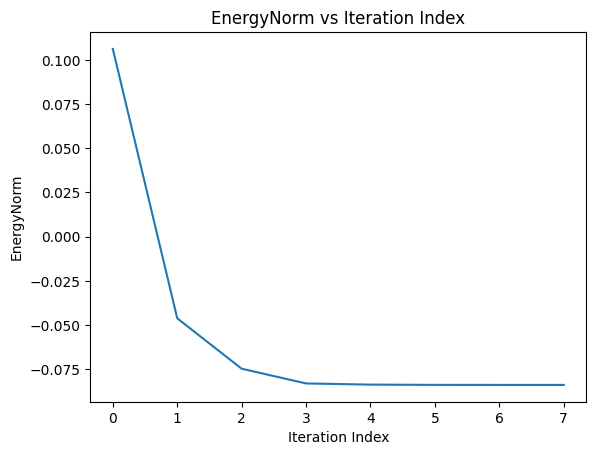

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming enorm_history is defined
df = pd.DataFrame(enorm_history, columns=["Iteration Index", "EnergyNorm"])
# Print the DataFrame
print(df)

# Plot the EnergyNorm against the index
plt.plot(df['Iteration Index'], df['EnergyNorm'])
plt.xlabel('Iteration Index')
plt.ylabel('EnergyNorm')
plt.title('EnergyNorm vs Iteration Index')
plt.show()
